In [247]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split , StratifiedKFold
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout,ReLU
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC

In [248]:
df = pd.read_csv('data/Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,unexplained_infertility,previous_miscarriages,label
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,0,1,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,0,1
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,0,1,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,0,1


In [249]:
tabular_data = df.drop(['id' , 'label'] , axis=1)
labels = df['label']

In [250]:
image_folder = r"C:\Users\User\Desktop\Junior\Machine\Machine Project\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"
image_list = []

for image_id in df['id']:
    img_name = f"{int(image_id):04d}.jpg"
    

    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image not found: {img_path}")
        continue

    img = img/255.0

    img= img[..., np.newaxis]
    image_list.append(img)

x_img = np.array(image_list, dtype=np.float32)
print(f"Image data shape: {x_img.shape}")


Image data shape: (128, 256, 256, 1)


In [251]:
X_tab_trainval, X_tab_test, X_img_trainval, X_img_test, y_trainval, y_test = train_test_split(
    tabular_data, x_img, labels, test_size=0.3, stratify=labels, random_state=42
)

print("--- Tabular Data ---")
print(f"TrainVal Tabular: {X_tab_trainval.shape}") 
print(f"Test Tabular:     {X_tab_test.shape}")


print("\n--- Image Data ---")
print(f"TrainVal Images:  {X_img_trainval.shape}") 
print(f"Test Images:      {X_img_test.shape}")


--- Tabular Data ---
TrainVal Tabular: (89, 400)
Test Tabular:     (39, 400)

--- Image Data ---
TrainVal Images:  (89, 256, 256, 1)
Test Images:      (39, 256, 256, 1)


In [252]:
image_input = Input(shape=(256, 256, 1))

x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.2)(x)
x = RandomZoom(0.2)(x)

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)


x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)


x = GlobalAveragePooling2D()(x)

x = Dense(64 , kernel_regularizer=l2(1e-3), activation='relu' , name="cnn_features")(x)
x = Dropout(0.3)(x)

cnn_feature_extractor = Model(inputs=image_input, outputs=x)
cnn_feature_extractor.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_16 (RandomFlip)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_16              │ (None, 256, 256, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_16 (RandomZoom)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_48 (ReLU)                 │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_49 (ReLU)                 │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_50 (ReLU)                 │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_features (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,824 (397.75 KB)

 Trainable params: 101,376 (396.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [253]:
cnn_features = cnn_feature_extractor.predict(x_img) 
print(f"CNN features shape: {cnn_features.shape}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
CNN features shape: (128, 64)


In [254]:
X_combined = np.concatenate([tabular_data, cnn_features], axis=1)
print(f"Combined features shape: {X_combined.shape}") 


Combined features shape: (128, 464)


In [255]:
# Lists to store results for each fold
cv_train_acc = [] 
cv_val_acc = []
cv_val_auc = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tab_trainval, y_trainval), 1):

    print(f"\n===== Fold {fold} =====")

   
    X_tab_train = X_tab_trainval.iloc[train_idx]
    X_tab_val   = X_tab_trainval.iloc[val_idx]

    X_img_train = X_img_trainval[train_idx]
    X_img_val   = X_img_trainval[val_idx]

    y_train = y_trainval.iloc[train_idx]
    y_val   = y_trainval.iloc[val_idx]

    print(f"DEBUG: Fold {fold} Shapes:")
    print(f"  - Training samples: {X_img_train.shape[0]}")
    print(f"  - Validation samples: {X_img_val.shape[0]}")
   

    tab_scaler = StandardScaler()
    X_tab_train = tab_scaler.fit_transform(X_tab_train)
    X_tab_val   = tab_scaler.transform(X_tab_val)

    
    train_cnn = cnn_feature_extractor.predict(X_img_train,verbose=0)
    val_cnn   = cnn_feature_extractor.predict(X_img_val,verbose=0)

 
    X_train_comb = np.concatenate([X_tab_train, train_cnn], axis=1)
    X_val_comb   = np.concatenate([X_tab_val, val_cnn], axis=1)

    #PCA
    pca = PCA(n_components=0.96) 
    X_train_pca = pca.fit_transform(X_train_comb)
    X_val_pca   = pca.transform(X_val_comb)
    print(f"Features reduced from {X_train_comb.shape[1]} to {X_train_pca.shape[1]}")

    comb_scaler = StandardScaler()
    X_train_scaled = comb_scaler.fit_transform(X_train_pca)
    X_val_scaled   = comb_scaler.transform(X_val_pca)

  
    svm = SVC(kernel='rbf', C=5.0, gamma=0.001 , class_weight='balanced')
    svm.fit(X_train_scaled, y_train)

    
    train_pred = svm.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    cv_train_acc.append(train_acc)

  
    val_pred = svm.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    cv_val_acc.append(val_acc)

    val_scores = svm.decision_function(X_val_scaled)
    fpr, tpr, _ = roc_curve(y_val, val_scores)
    val_auc = auc(fpr, tpr)
    cv_val_auc.append(val_auc)

    print(f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Val ROC-AUC: {val_auc:.3f}")

# Final Cross-Validation Summary
print("\n" + "="*25)
print(f"Mean CV Train Accuracy: {np.mean(cv_train_acc):.3f}")
print(f"Mean CV Val Accuracy:   {np.mean(cv_val_acc):.3f}")
print(f"Mean CV Val ROC-AUC:    {np.mean(cv_val_auc):.3f}")


===== Fold 1 =====
DEBUG: Fold 1 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 464 to 18
Train Acc: 0.817 | Val Acc: 0.722 | Val ROC-AUC: 0.827

===== Fold 2 =====
DEBUG: Fold 2 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 464 to 18
Train Acc: 0.803 | Val Acc: 0.611 | Val ROC-AUC: 0.704

===== Fold 3 =====
DEBUG: Fold 3 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 464 to 18
Train Acc: 0.859 | Val Acc: 0.556 | Val ROC-AUC: 0.575

===== Fold 4 =====
DEBUG: Fold 4 Shapes:
  - Training samples: 71
  - Validation samples: 18
Features reduced from 464 to 18
Train Acc: 0.775 | Val Acc: 0.778 | Val ROC-AUC: 0.887

===== Fold 5 =====
DEBUG: Fold 5 Shapes:
  - Training samples: 72
  - Validation samples: 17
Features reduced from 464 to 18
Train Acc: 0.778 | Val Acc: 0.706 | Val ROC-AUC: 0.764

Mean CV Train Accuracy: 0.806
Mean CV Val Accuracy:   0.675
Mean CV Val ROC-AUC:    0.751


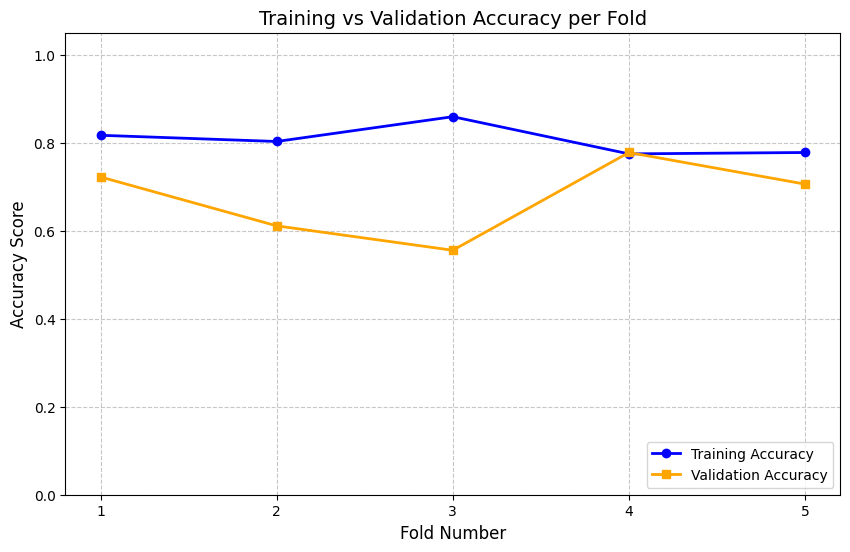

In [256]:
import matplotlib.pyplot as plt


folds = range(1, len(cv_train_acc) + 1)

plt.figure(figsize=(10, 6))


plt.plot(folds, cv_train_acc, 'o-', label='Training Accuracy', color='blue', linewidth=2)


plt.plot(folds, cv_val_acc, 's-', label='Validation Accuracy', color='orange', linewidth=2)


plt.title('Training vs Validation Accuracy per Fold', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(folds) 
plt.ylim(0, 1.05) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')



In [257]:
#final Test Evaluation
tab_scaler = StandardScaler()
X_tab_trainval_scaled = tab_scaler.fit_transform(X_tab_trainval)
X_tab_test_scaled     = tab_scaler.transform(X_tab_test)


trainval_cnn = cnn_feature_extractor.predict(X_img_trainval)
test_cnn     = cnn_feature_extractor.predict(X_img_test)


X_trainval_comb = np.concatenate([X_tab_trainval_scaled, trainval_cnn], axis=1)
X_test_comb     = np.concatenate([X_tab_test_scaled, test_cnn], axis=1)

#PCA
pca_final = PCA(n_components=0.96)
X_trainval_pca = pca_final.fit_transform(X_trainval_comb)

X_test_pca = pca_final.transform(X_test_comb)

comb_scaler = StandardScaler()
X_trainval_scaled = comb_scaler.fit_transform(X_trainval_pca)
X_test_scaled     = comb_scaler.transform(X_test_pca)


svm_final = SVC(kernel='rbf', C=5.0, gamma=0.001 ,class_weight='balanced')
svm_final.fit(X_trainval_scaled, y_trainval)

test_pred = svm_final.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)

test_scores = svm_final.decision_function(X_test_scaled)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
test_auc = auc(fpr_test, tpr_test)

print("\nFinal Test Accuracy:", test_acc)
print("Final Test ROC-AUC:", test_auc)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 

Final Test Accuracy: 0.7435897435897436
Final Test ROC-AUC: 0.7804232804232805


In [258]:
from scipy.special import expit
test_probs = expit(test_scores)
results_df = pd.DataFrame({
    'id': df.loc[y_test.index,'id'].values,
    'prob': test_probs
})

results_df.to_csv('cnn_svm_preds.csv', index=False)
print("Saved cnn_svm_preds.csv successfully!")

Saved cnn_svm_preds.csv successfully!


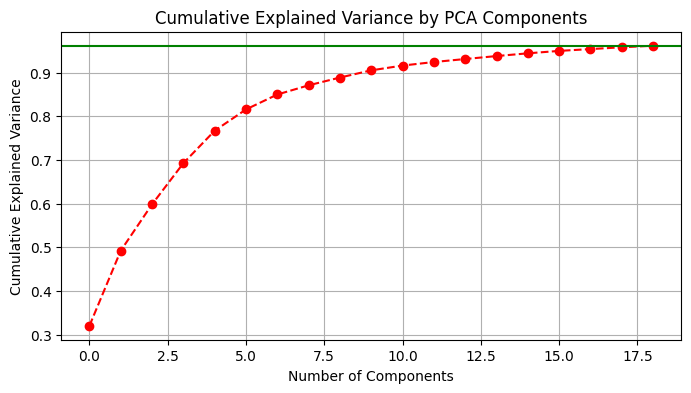

In [259]:
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca_final.explained_variance_ratio_), marker='o', linestyle='--', color='red')
plt.axhline(y=0.96, color='g', linestyle='-')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

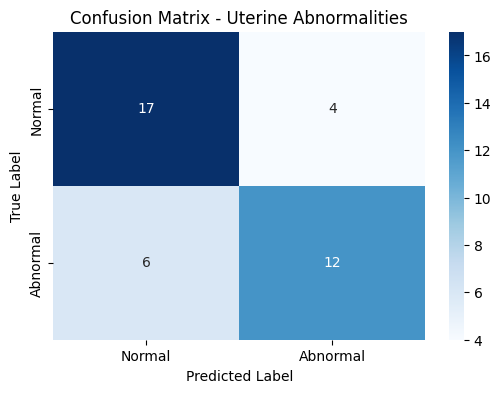

              precision    recall  f1-score   support

      Normal       0.74      0.81      0.77        21
    Abnormal       0.75      0.67      0.71        18

    accuracy                           0.74        39
   macro avg       0.74      0.74      0.74        39
weighted avg       0.74      0.74      0.74        39



In [260]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' ,xticklabels=["Normal", "Abnormal"],
   yticklabels=["Normal", "Abnormal"])
plt.title("Confusion Matrix - Uterine Abnormalities")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

target_names =['Normal' , 'Abnormal']
print(classification_report(y_test, test_pred , target_names=target_names))